# Libraries

In [1]:
from matplotlib.pylab import *
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
import torch
import torch.nn as nn
from torch.optim import SGD
from torchviz import make_dot
from tqdm import tqdm
from datetime import datetime
from random import uniform
import wandb

num_lessons = 10
current_time = datetime.now().strftime("%Y-%m-%d_%I-%M%p")
π = pi
style.use(['dark_background', 'bmh'])
%matplotlib notebook

![car-trailer](figures/truck-backer-upper.png)


\begin{align}
\dot x &= s \cos \theta_0 \\
\dot y &= s \sin \theta_0 \\
\dot \theta_0 &= \frac{s}{L} \tan \phi \\
\dot \theta_1 &= \frac{s}{d_1} \sin(\theta_1 - \theta_0)
\end{align}

# Preparing Lessons

In [2]:
def create_lesson_configs(num_lessons):
    configs = {}

    first_lesson = {"θ0_range": (0, 10),
                    "Δθ1_range": (-10, 10),
                    "x_range": (10, 10),
                    "y_range": (-2, 2)}
    
    final_lesson = {"θ0_range": (0, 120),
                    "Δθ1_range": (-45, 45),
                    "x_range": (10, 35),
                    "y_range": (-7, 7)}

    x_min = first_lesson["x_range"][0]

    for i in range(1, num_lessons + 1):

        θ0_max = first_lesson["θ0_range"][1] + (final_lesson["θ0_range"][1] - 
                                                first_lesson["θ0_range"][1]) * (i - 1) // (num_lessons - 1)
        
        Δθ1_max = first_lesson["Δθ1_range"][1] + (final_lesson["Δθ1_range"][1] - 
                                                  first_lesson["Δθ1_range"][1]) * (i - 1) // (num_lessons - 1)
        
        x_max = first_lesson["x_range"][1] + (final_lesson["x_range"][1] - 
                                              first_lesson["x_range"][1]) * (i - 1) // (num_lessons - 1)
        
        y_max = first_lesson["y_range"][1] + (final_lesson["y_range"][1] - 
                                              first_lesson["y_range"][1]) * (i - 1) // (num_lessons - 1)

        configs[i] = {"θ0_range": (0, θ0_max),
                      "Δθ1_range": (-Δθ1_max, Δθ1_max),
                      "x_range": (x_min, x_max),
                      "y_range": (-y_max, y_max)}
        x_min = x_max
        
    configs[num_lessons+1] = final_lesson
    return configs

LESSON_CONFIGS = create_lesson_configs(num_lessons)

# Initializing Truck

In [3]:
class Truck:
    def __init__(self, lesson, display=False):

        self.W = 1 
        self.L = 1 * self.W 
        self.d = 4 * self.L 
        self.s = -0.2  
        self.display = display
        self.lesson = lesson
        
        self.box = [0, 40, -10, 10]
        if self.display:
            self.f = figure(figsize=(6, 3), num='The Truck Backer-Upper', facecolor='none')
            self.ax = self.f.add_axes([0.01, 0.01, 0.98, 0.98], facecolor='black')
            self.patches = list()
            
            self.ax.axis('equal')
            b = self.box
            self.ax.axis([b[0] - 1, b[1], b[2], b[3]])
            self.ax.set_xticks([]); self.ax.set_yticks([])
            self.ax.axhline(); self.ax.axvline()
            
    def reset(self, ϕ=0):
        self.ϕ = ϕ 
        config = LESSON_CONFIGS.get(self.lesson)
        
        if config is None: 
            raise ValueError(f"No configuration found for lesson {self.lesson}")       
            
        self.θ0 = deg2rad(uniform(*config["θ0_range"]))
        self.θ1 = deg2rad(uniform(*config["Δθ1_range"])) + self.θ0
        self.x = uniform(*config["x_range"])
        self.y = uniform(*config["y_range"])      
        
        # If poorly initialise, then re-initialise
        if not self.valid():
            self.reset(ϕ)
        
        # Draw, if display is True
        if self.display: 
            self.draw()        
    
    def step(self, ϕ=0, dt=1):
        
        # Check for illegal conditions
        if self.is_jackknifed():
            print('The truck is jackknifed!')
            return
        
        if self.is_offscreen():
            print('The car or trailer is off screen')
            return
        
        self.ϕ = ϕ
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        # Perform state update
        self.x += s * cos(θ0) * dt
        self.y += s * sin(θ0) * dt
        self.θ0 += s / L * tan(ϕ) * dt
        self.θ1 += s / d * sin(θ0 - θ1) * dt   
                        
        return (self.x, self.y, self.θ0, *self._trailer_xy(), self.θ1)
    
    def state(self):
        return (self.x, self.y, self.θ0, *self._trailer_xy(), self.θ1)
    
    def _get_atributes(self):
        return (
            self.x, self.y, self.W, self.L, self.d, self.s,
            self.θ0, self.θ1, self.ϕ
        )
    
    def _trailer_xy(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return x - d * cos(θ1), y - d * sin(θ1)
        
    def is_jackknifed(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        angle_diff_rad = abs(θ0 - θ1)
        angle_diff_deg = rad2deg(angle_diff_rad)
        return angle_diff_deg > 90
    
    def is_offscreen(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        x1, y1 = x + 1.5 * L * cos(θ0), y + 1.5 * L * sin(θ0)
        x2, y2 = self._trailer_xy()
        
        b = self.box
        return not (
            b[0] <= x1 <= b[1] and b[2] <= y1 <= b[3] and
            b[0] <= x2 <= b[1] and b[2] <= y2 <= b[3]
        )
        
    def valid(self):
        return not self.is_jackknifed() and not self.is_offscreen()
        
    def draw(self):
        if not self.display: return
        if self.patches: self.clear()
        self._draw_car()
        self._draw_trailer()
        self.f.canvas.draw()
            
    def clear(self):
        for p in self.patches:
            p.remove()
        self.patches = list()
        
    def _draw_car(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()

        ax = self.ax
        
        x1, y1 = x + L / 2 * cos(θ0), y + L / 2 * sin(θ0)
        bar = Line2D((x, x1), (y, y1), lw=5, color='C2', alpha=1)
        ax.add_line(bar)

        car = Rectangle((x1, y1 - W / 2),   
                        L,                  
                        W,                  
                        color='C2',        
                        alpha=1,
                        transform=(matplotlib.transforms.Affine2D().rotate_deg_around(x1, y1, rad2deg(θ0)) +
                                   ax.transData))

        ax.add_patch(car)

        x2, y2 = x1 + L / 2 ** 0.5 * cos(θ0 + π / 4), y1 + L / 2 ** 0.5 * sin(θ0 + π / 4)
        left_wheel = Line2D(
            (x2 - L / 4 * cos(θ0 + ϕ), x2 + L / 4 * cos(θ0 + ϕ)),
            (y2 - L / 4 * sin(θ0 + ϕ), y2 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(left_wheel)

        x3, y3 = x1 + L / 2 ** 0.5 * cos(π / 4 - θ0), y1 - L / 2 ** 0.5 * sin(π / 4 - θ0)
        right_wheel = Line2D(
            (x3 - L / 4 * cos(θ0 + ϕ), x3 + L / 4 * cos(θ0 + ϕ)),
            (y3 - L / 4 * sin(θ0 + ϕ), y3 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(right_wheel)
        
        self.patches += [car, bar, left_wheel, right_wheel]
        
    def _draw_trailer(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()    
        ax = self.ax
             
        x, y = x - d * cos(θ1), y - d * sin(θ1) - W / 2
        trailer = Rectangle((x, y),   
                            d,        
                            W,        
                            color='C0', 
                            alpha=1,
                            transform = (matplotlib.transforms.Affine2D().rotate_deg_around(x, y + W / 2, rad2deg(θ1)) + 
                                         ax.transData))

        ax.add_patch(trailer)
        
        self.patches += [trailer]
        
    def update_state(self, state): 
        self.ϕ, self.x, self.y, self.θ0, _, _, self.θ1 = state.tolist()

# Defining Functions to Train Emulator and Controller

In [4]:
def generate_random_deg(mean, std, scale_lower, scale_upper): 
    random_num = np.random.normal(loc = mean, scale = std)
    random_num_scaled = np.clip(random_num, scale_lower, scale_upper)
    return random_num_scaled

In [5]:
def initialize_emulator(): 
    emulator = nn.Sequential(
        nn.Linear(7, 100),
        nn.GELU(),
        nn.Linear(100, 100),
        nn.GELU(),
        nn.Linear(100, 6)
    )

    torch.save(emulator, 'models/emulators/emulator_lesson_0.pth')
    return emulator


def initialize_controller():
    controller = nn.Sequential( 
        nn.Linear(7, 50),
        nn.Tanh(),
        nn.Linear(50, 1)
    )
          
    torch.save(controller, 'models/controllers/controller_lesson_0.pth')
    return controller

In [6]:
criterion_emulator = nn.MSELoss()  

def criterion_controller(ϕ_state, step):
    _, _, _, θ0, x, y, θ1 = ϕ_state 
    angle_diff_rad = torch.abs(θ1 - θ0)
    angle_diff_deg = torch.rad2deg(angle_diff_rad)
    angle_diff_relu = nn.functional.relu((angle_diff_deg - 30)/30)
    x_relu = nn.functional.relu(x)
    min_θ1 = torch.min(torch.abs(θ1), torch.abs(torch.abs(θ1) - torch.deg2rad(torch.tensor(360.0))))
    part1 = x_relu + torch.abs(y) + min_θ1
    part2 = (x_relu**2 + y**2 + min_θ1**2 + angle_diff_relu**2 + step * 0.01)
    return -torch.log(1 / (part1 * part2))

In [7]:
def train_emulator(emulator, 
                   episodes, 
                   learning_rate, 
                   lesson, 
                   wandb_log = False):
    
    if wandb_log:
        wandb.init(project='emulator-training', save_code = True, name=f'lesson_{lesson}_run_{current_time}')
        
    inputs = list()
    outputs = list()
    truck = Truck(lesson)
    for episode in tqdm(range(episodes)):
        truck.reset()
        while truck.valid():
            initial_state = truck.state()
            random_deg = generate_random_deg(mean = 0, 
                                             std = 35, 
                                             scale_lower = -70, 
                                             scale_upper = 70)
            ϕ = deg2rad(random_deg)
            inputs.append((ϕ, *initial_state))
            outputs.append(truck.step(ϕ))
            
    tensor_inputs = torch.Tensor(inputs)
    tensor_outputs = torch.Tensor(outputs)
    
    test_size = int(len(tensor_inputs) * 0.8)
    
    train_inputs = tensor_inputs[:test_size]
    train_outputs = tensor_outputs[:test_size]
    
    test_inputs = tensor_inputs[test_size:]
    test_outputs = tensor_outputs[test_size:]
    
    print("Train Size:", len(train_inputs))
    print("Test Size:", len(test_inputs))
    
    optimizer = torch.optim.Adam(emulator.parameters(), lr=learning_rate)
    
    global_step = 0
    for i in torch.randperm(len(train_inputs)):
        ϕ_state = train_inputs[i]
        
        next_state_prediction = emulator(ϕ_state)
        next_state = train_outputs[i]
        
        optimizer.zero_grad()
        
        loss = criterion_emulator(next_state_prediction, next_state)
        loss.backward()
        
        if wandb_log:
            wandb.log({'train_loss': loss.item(),
                       'gradients': {name: param.grad.norm().item() for name, param in emulator.named_parameters() if param.grad is not None}}, step=global_step)
        
        optimizer.step()
        global_step += 1

    with torch.no_grad():
        total_loss = 0
        for j in range(len(test_inputs)):
            ϕ_state = test_inputs[j]
            next_state = test_outputs[j]
            
            next_state_prediction = emulator(ϕ_state)
            
            loss = criterion_emulator(next_state_prediction, next_state)
            total_loss += loss.item()
            
            if wandb_log:
                wandb.log({'test_loss': loss.item()}, step = global_step)
                
            global_step += 1

    test_size = len(test_inputs)
    avg_test_loss = total_loss / test_size
    
    print()
    print(f'Test loss: {avg_test_loss:.10f}')
    
    torch.save(emulator, f'models/emulators/emulator_lesson_{lesson}.pth')
    
    if wandb_log:
        wandb.finish()
    
    return emulator

In [8]:
def train_controller(lesson, 
                     controller, 
                     epochs, 
                     max_steps,
                     wandb_log = False,
                     save_computational_graph = False,
                     learning_rate = 0.0001):
      
    if wandb_log: 
        wandb.init(project='controller-training', save_code = True, name=f'lesson_{lesson}_run_{current_time}')
      
    emulator = torch.load('models/emulators/emulator_lesson_{}.pth'.format(lesson), weights_only=False)
    optimizer = torch.optim.Adam(controller.parameters(), lr=learning_rate, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
    truck = Truck(lesson, display=False)
    
    for i in tqdm(range(epochs)):
        truck.reset()
        random_deg = generate_random_deg(mean = 0, 
                                         std = 70, 
                                         scale_lower = -70, 
                                         scale_upper = 70)
        ϕ = deg2rad(random_deg)
        state = truck.state()
        ϕ_state = torch.cat((torch.tensor([ϕ], dtype=torch.float32), 
                             torch.tensor(state, dtype=torch.float32))) 
        step = torch.tensor(0.0)
        
        while step <= max_steps and truck.valid():
            ϕ_prediction = controller(ϕ_state)
            next_state_prediction = emulator(ϕ_state)
            ϕ_state = torch.cat((ϕ_prediction, next_state_prediction))
            truck.update_state(ϕ_state)
            step += 1
        
        optimizer.zero_grad()
        loss = criterion_controller(ϕ_state, step)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(parameters = controller.parameters(),               
                                       max_norm = 1, 
                                       error_if_nonfinite = True)        
        
        if wandb_log:
            wandb.log({'loss': loss.item(),
                       'gradients': {name: param.grad.norm().item() for name, param in controller.named_parameters() if param.grad is not None}}, step=i)

        
        if save_computational_graph and i == 0 and lesson == 1: 
            dot = make_dot(loss, params=dict(controller.named_parameters()))
            dot.format = 'png'
            dot.render('computational-graphs/controller_computational_graph')
        
        optimizer.step()
        scheduler.step()
        
        if i % 100 == 0:
            torch.save(controller, 'models/controllers/controller_lesson_{}.pth'.format(lesson))
            loss_value = loss.item()
            print(f'{loss_value:.10f}')
    
    if wandb_log:
        wandb.finish()
            
    return controller

# Training Emulators

In [9]:
!rm -r models/emulators
!mkdir models/emulators

In [10]:
emulator = initialize_emulator()

for lesson in range(1, num_lessons + 2): 
    print(" Lesson {}:".format(lesson))
    emulator = train_emulator(lesson = lesson,
                              emulator = emulator, 
                              episodes = 10_000,
                              learning_rate = 0.00001)
    print()

 Lesson 1:


100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1800.10it/s]


Train Size: 230979
Test Size: 57745

Test loss: 0.0008695917

 Lesson 2:


100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1676.34it/s]


Train Size: 247976
Test Size: 61994

Test loss: 0.0006438097

 Lesson 3:


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1556.64it/s]


Train Size: 266541
Test Size: 66636

Test loss: 0.0010606300

 Lesson 4:


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1550.28it/s]


Train Size: 267716
Test Size: 66929

Test loss: 0.0006416024

 Lesson 5:


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1653.92it/s]


Train Size: 256798
Test Size: 64200

Test loss: 0.0005987183

 Lesson 6:


100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1691.23it/s]


Train Size: 245916
Test Size: 61480

Test loss: 0.0005232790

 Lesson 7:


100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1765.52it/s]


Train Size: 237566
Test Size: 59392

Test loss: 0.0006134627

 Lesson 8:


100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1853.01it/s]


Train Size: 228032
Test Size: 57009

Test loss: 0.0005375776

 Lesson 9:


100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1870.15it/s]


Train Size: 215216
Test Size: 53804

Test loss: 0.0006486412

 Lesson 10:


100%|███████████████████████████████████| 10000/10000 [00:04<00:00, 2037.09it/s]


Train Size: 201387
Test Size: 50347

Test loss: 0.0005553037

 Lesson 11:


100%|███████████████████████████████████| 10000/10000 [00:04<00:00, 2004.39it/s]


Train Size: 208244
Test Size: 52062

Test loss: 0.0007159908



 # Training Controllers

In [11]:
!rm -rf models/controllers
!mkdir models/controllers

In [12]:
controller = initialize_controller()

for lesson in range(1, num_lessons + 2): 
    print(" Lesson {}:".format(lesson))
    controller = train_controller(lesson = lesson, 
                                  controller = controller, 
                                  epochs = 3000,
                                  max_steps = 400)
    print()

 Lesson 1:


  0%|                                                  | 0/3000 [00:00<?, ?it/s]

5.3225259781


  4%|█▍                                     | 111/3000 [00:00<00:26, 109.27it/s]

4.5855989456


  7%|██▊                                    | 219/3000 [00:01<00:26, 103.39it/s]

4.4356689453


 11%|████                                   | 316/3000 [00:02<00:25, 106.39it/s]

5.6430168152


 14%|█████▎                                 | 413/3000 [00:03<00:23, 110.47it/s]

4.0378675461


 17%|██████▋                                | 516/3000 [00:04<00:24, 103.20it/s]

4.6353573799


 20%|████████▏                               | 615/3000 [00:05<00:25, 93.71it/s]

0.3528463840


 24%|█████████▎                             | 716/3000 [00:06<00:20, 108.82it/s]

0.4175578654


 27%|██████████▌                            | 812/3000 [00:07<00:20, 105.27it/s]

1.9930747747


 30%|███████████▊                           | 913/3000 [00:08<00:20, 100.71it/s]

-1.1297348738


 34%|████████████▊                         | 1012/3000 [00:09<00:19, 100.79it/s]

6.1820306778


 37%|██████████████▌                        | 1119/3000 [00:10<00:19, 97.95it/s]

3.3333399296


 41%|███████████████▍                      | 1216/3000 [00:11<00:17, 100.47it/s]

3.0132775307


 44%|█████████████████▏                     | 1320/3000 [00:12<00:17, 95.81it/s]

-0.2992126942


 47%|█████████████████▊                    | 1410/3000 [00:13<00:14, 107.46it/s]

2.1940982342


 50%|███████████████████▋                   | 1513/3000 [00:14<00:17, 86.79it/s]

2.4075272083


 54%|█████████████████████                  | 1617/3000 [00:16<00:14, 93.24it/s]

2.8597662449


 57%|██████████████████████▎                | 1718/3000 [00:17<00:13, 94.16it/s]

0.3193141222


 60%|███████████████████████▌               | 1814/3000 [00:18<00:12, 97.21it/s]

4.5923404694


 64%|████████████████████████▏             | 1911/3000 [00:19<00:10, 100.73it/s]

3.4595417976


 67%|██████████████████████████▏            | 2017/3000 [00:20<00:10, 92.87it/s]

1.3330920935


 70%|███████████████████████████▍           | 2110/3000 [00:21<00:09, 96.04it/s]

2.6986854076


 74%|████████████████████████████▋          | 2209/3000 [00:22<00:09, 87.35it/s]

0.8744913936


 77%|██████████████████████████████▏        | 2319/3000 [00:23<00:07, 94.16it/s]

0.1189073026


 80%|███████████████████████████████▍       | 2414/3000 [00:24<00:06, 97.24it/s]

3.6422407627


 84%|███████████████████████████████▊      | 2513/3000 [00:25<00:04, 102.26it/s]

-0.1788056046


 87%|██████████████████████████████████     | 2619/3000 [00:26<00:03, 97.49it/s]

0.7890009284


 90%|███████████████████████████████████▎   | 2714/3000 [00:27<00:03, 94.61it/s]

0.0491750054


 94%|████████████████████████████████████▌  | 2809/3000 [00:28<00:02, 93.69it/s]

2.3772611618


 97%|████████████████████████████████████▉ | 2920/3000 [00:29<00:00, 106.39it/s]

2.6908819675


100%|███████████████████████████████████████| 3000/3000 [00:30<00:00, 98.54it/s]



 Lesson 2:


  0%|▏                                         | 9/3000 [00:00<00:38, 78.22it/s]

3.0123777390


  4%|█▍                                      | 110/3000 [00:01<00:36, 78.12it/s]

3.3485932350


  7%|██▊                                     | 211/3000 [00:02<00:34, 81.36it/s]

4.9637231827


 11%|████▏                                   | 316/3000 [00:04<00:33, 81.01it/s]

4.4572873116


 14%|█████▌                                  | 414/3000 [00:05<00:31, 81.97it/s]

1.2400290966


 17%|██████▉                                 | 516/3000 [00:06<00:28, 87.89it/s]

0.3531074226


 20%|████████▏                               | 615/3000 [00:07<00:30, 78.99it/s]

2.3964107037


 24%|█████████▍                              | 712/3000 [00:08<00:26, 86.14it/s]

-0.4651322961


 27%|██████████▉                             | 816/3000 [00:10<00:28, 76.16it/s]

1.7191672325


 30%|████████████▏                           | 913/3000 [00:11<00:24, 83.82it/s]

0.4500690997


 34%|█████████████▏                         | 1010/3000 [00:12<00:22, 87.02it/s]

-1.0771782398


 37%|██████████████▍                        | 1115/3000 [00:13<00:20, 90.84it/s]

-1.8589594364


 40%|███████████████▊                       | 1215/3000 [00:14<00:19, 93.28it/s]

-0.2254359424


 44%|█████████████████                      | 1315/3000 [00:15<00:17, 94.71it/s]

-1.9236991405


 47%|██████████████████▍                    | 1416/3000 [00:16<00:16, 93.60it/s]

-0.8262761235


 51%|███████████████████▋                   | 1517/3000 [00:18<00:15, 93.98it/s]

-1.6991089582


 54%|████████████████████▉                  | 1615/3000 [00:19<00:17, 80.69it/s]

-2.1295423508


 57%|██████████████████████▎                | 1717/3000 [00:20<00:14, 85.77it/s]

-0.2659300268


 60%|███████████████████████▌               | 1812/3000 [00:21<00:13, 89.03it/s]

-0.7346318960


 64%|████████████████████████▉              | 1918/3000 [00:22<00:12, 89.71it/s]

-1.0466037989


 67%|██████████████████████████▏            | 2011/3000 [00:23<00:10, 95.87it/s]

-1.0944317579


 70%|███████████████████████████▍           | 2111/3000 [00:24<00:09, 90.35it/s]

-2.0867280960


 74%|████████████████████████████▊          | 2220/3000 [00:25<00:08, 94.53it/s]

-1.8893542290


 77%|██████████████████████████████         | 2317/3000 [00:27<00:07, 96.40it/s]

-1.0060591698


 81%|███████████████████████████████▍       | 2420/3000 [00:28<00:06, 95.64it/s]

0.2019269913


 84%|████████████████████████████████▋      | 2511/3000 [00:29<00:05, 94.32it/s]

-2.3495969772


 87%|█████████████████████████████████▉     | 2615/3000 [00:30<00:04, 93.01it/s]

-2.1585805416


 91%|███████████████████████████████████▎   | 2717/3000 [00:31<00:03, 91.49it/s]

0.1715272665


 94%|███████████████████████████████████▋  | 2817/3000 [00:32<00:01, 101.08it/s]

-2.6563794613


 97%|█████████████████████████████████████▉ | 2915/3000 [00:33<00:00, 96.76it/s]

-2.7081439495


100%|███████████████████████████████████████| 3000/3000 [00:34<00:00, 87.88it/s]



 Lesson 3:


  0%|▏                                         | 9/3000 [00:00<00:40, 74.66it/s]

-0.3969697952


  4%|█▍                                      | 109/3000 [00:01<00:40, 71.00it/s]

-2.0051262379


  7%|██▊                                     | 213/3000 [00:02<00:40, 69.41it/s]

-3.3509118557


 10%|████▏                                   | 312/3000 [00:04<00:37, 72.16it/s]

-2.6990337372


 14%|█████▍                                  | 408/3000 [00:05<00:34, 74.75it/s]

-3.1402118206


 17%|██████▊                                 | 513/3000 [00:07<00:36, 67.58it/s]

-2.5770194530


 20%|████████                                | 608/3000 [00:08<00:35, 67.99it/s]

-1.5517185926


 24%|█████████▌                              | 715/3000 [00:09<00:33, 68.19it/s]

-0.5364331603


 27%|██████████▊                             | 814/3000 [00:11<00:31, 69.68it/s]

-2.3801987171


 30%|████████████▏                           | 910/3000 [00:12<00:28, 72.78it/s]

-0.6754983664


 34%|█████████████▏                         | 1013/3000 [00:14<00:29, 66.80it/s]

-1.4833905697


 37%|██████████████▍                        | 1109/3000 [00:15<00:28, 67.29it/s]

-1.5416010618


 40%|███████████████▋                       | 1209/3000 [00:17<00:24, 73.06it/s]

0.3283336759


 44%|█████████████████                      | 1308/3000 [00:18<00:23, 72.29it/s]

-1.9125807285


 47%|██████████████████▎                    | 1410/3000 [00:20<00:24, 63.66it/s]

-1.3724874258


 50%|███████████████████▋                   | 1512/3000 [00:21<00:21, 69.34it/s]

-2.2942163944


 54%|████████████████████▉                  | 1606/3000 [00:22<00:19, 71.83it/s]

-1.3721548319


 57%|██████████████████████▏                | 1707/3000 [00:24<00:18, 69.72it/s]

-1.3811249733


 60%|███████████████████████▌               | 1813/3000 [00:25<00:16, 71.38it/s]

-2.4281654358


 64%|████████████████████████▉              | 1915/3000 [00:27<00:14, 73.08it/s]

-1.4736956358


 67%|██████████████████████████             | 2009/3000 [00:28<00:14, 69.53it/s]

-3.0228767395


 70%|███████████████████████████▍           | 2112/3000 [00:30<00:12, 72.71it/s]

-2.0428466797


 74%|████████████████████████████▋          | 2208/3000 [00:31<00:11, 68.23it/s]

-1.8400017023


 77%|██████████████████████████████         | 2308/3000 [00:32<00:09, 72.01it/s]

-2.0650417805


 80%|███████████████████████████████▎       | 2411/3000 [00:34<00:08, 70.03it/s]

-1.6135778427


 84%|████████████████████████████████▋      | 2515/3000 [00:35<00:06, 70.73it/s]

-1.8114582300


 87%|█████████████████████████████████▉     | 2612/3000 [00:37<00:05, 66.37it/s]

-2.7872695923


 90%|███████████████████████████████████▎   | 2715/3000 [00:38<00:04, 68.81it/s]

-2.6668777466


 94%|████████████████████████████████████▌  | 2809/3000 [00:40<00:02, 69.63it/s]

-1.2193086147


 97%|█████████████████████████████████████▊ | 2913/3000 [00:41<00:01, 68.51it/s]

-2.6233026981


100%|███████████████████████████████████████| 3000/3000 [00:42<00:00, 70.15it/s]



 Lesson 4:


  0%|▏                                         | 9/3000 [00:00<00:33, 89.87it/s]

7.7391738892


  4%|█▍                                      | 109/3000 [00:01<00:47, 60.86it/s]

1.0015981197


  7%|██▊                                     | 210/3000 [00:03<00:48, 57.22it/s]

-0.6545543671


 10%|████                                    | 308/3000 [00:05<00:47, 57.01it/s]

-1.1519974470


 14%|█████▍                                  | 409/3000 [00:07<00:48, 53.44it/s]

-1.9841854572


 17%|██████▊                                 | 510/3000 [00:09<00:46, 54.05it/s]

-2.8064243793


 20%|████████▏                               | 610/3000 [00:11<00:45, 52.58it/s]

0.7642381787


 24%|█████████▍                              | 709/3000 [00:12<00:42, 53.71it/s]

-1.5237196684


 27%|██████████▊                             | 809/3000 [00:14<00:40, 53.64it/s]

-1.6449836493


 30%|████████████▏                           | 911/3000 [00:16<00:39, 52.69it/s]

-3.1610805988


 34%|█████████████▏                         | 1012/3000 [00:18<00:32, 61.29it/s]

-0.8629279137


 37%|██████████████▍                        | 1108/3000 [00:19<00:31, 59.30it/s]

-1.1233704090


 40%|███████████████▊                       | 1212/3000 [00:21<00:33, 52.90it/s]

-3.2196872234


 44%|█████████████████                      | 1309/3000 [00:23<00:32, 52.41it/s]

-2.7486939430


 47%|██████████████████▎                    | 1411/3000 [00:25<00:31, 51.07it/s]

-1.6712267399


 50%|███████████████████▋                   | 1511/3000 [00:27<00:28, 52.38it/s]

-1.7314391136


 54%|████████████████████▉                  | 1611/3000 [00:29<00:25, 53.88it/s]

-0.2429366261


 57%|██████████████████████▏                | 1709/3000 [00:31<00:27, 47.41it/s]

-1.8636838198


 60%|███████████████████████▌               | 1808/3000 [00:33<00:22, 52.98it/s]

-2.3317933083


 64%|████████████████████████▊              | 1910/3000 [00:35<00:21, 50.36it/s]

-1.6377491951


 67%|██████████████████████████▏            | 2012/3000 [00:37<00:18, 53.56it/s]

-2.3537993431


 70%|███████████████████████████▍           | 2111/3000 [00:39<00:16, 54.50it/s]

-2.0829353333


 74%|████████████████████████████▋          | 2207/3000 [00:40<00:15, 52.06it/s]

-2.8379426003


 77%|██████████████████████████████         | 2310/3000 [00:42<00:12, 54.54it/s]

-4.0390720367


 80%|███████████████████████████████▍       | 2414/3000 [00:44<00:09, 63.18it/s]

-2.6968276501


 84%|████████████████████████████████▌      | 2508/3000 [00:46<00:08, 58.91it/s]

-1.5438503027


 87%|█████████████████████████████████▉     | 2608/3000 [00:47<00:07, 54.86it/s]

-2.2203018665


 90%|███████████████████████████████████▏   | 2711/3000 [00:49<00:05, 54.60it/s]

-3.3907206059


 94%|████████████████████████████████████▌  | 2809/3000 [00:51<00:03, 56.06it/s]

8.2350988388


 97%|█████████████████████████████████████▊ | 2907/3000 [00:53<00:01, 56.74it/s]

-4.1027903557


100%|███████████████████████████████████████| 3000/3000 [00:55<00:00, 54.51it/s]



 Lesson 5:


  0%|                                          | 6/3000 [00:00<00:56, 52.64it/s]

-1.1953716278


  4%|█▍                                      | 107/3000 [00:02<01:00, 47.63it/s]

-3.1244866848


  7%|██▊                                     | 207/3000 [00:04<01:01, 45.14it/s]

-3.6047544479


 10%|████                                    | 308/3000 [00:06<00:50, 53.41it/s]

-1.6409513950


 14%|█████▍                                  | 407/3000 [00:08<00:59, 43.56it/s]

-1.1987357140


 17%|██████▋                                 | 505/3000 [00:10<00:56, 43.80it/s]

-4.2792096138


 20%|████████▏                               | 610/3000 [00:12<00:44, 53.62it/s]

8.5561923981


 23%|█████████▍                              | 704/3000 [00:14<00:54, 42.52it/s]

-1.7169680595


 27%|██████████▋                             | 806/3000 [00:16<00:42, 51.46it/s]

-3.6309022903


 30%|████████████                            | 907/3000 [00:18<00:46, 45.43it/s]

-2.3246052265


 34%|█████████████                          | 1008/3000 [00:21<00:40, 49.46it/s]

-0.8412765861


 37%|██████████████▎                        | 1105/3000 [00:23<00:43, 43.16it/s]

-3.1305799484


 40%|███████████████▋                       | 1208/3000 [00:25<00:39, 45.59it/s]

-3.7624933720


 44%|█████████████████                      | 1308/3000 [00:27<00:33, 50.53it/s]

-2.6697340012


 47%|██████████████████▎                    | 1411/3000 [00:29<00:35, 44.72it/s]

-3.2851393223


 50%|███████████████████▌                   | 1506/3000 [00:31<00:33, 44.68it/s]

-4.9697690010


 54%|████████████████████▉                  | 1607/3000 [00:34<00:29, 46.51it/s]

-2.7108676434


 57%|██████████████████████▏                | 1710/3000 [00:36<00:28, 45.53it/s]

8.8533878326


 60%|███████████████████████▌               | 1810/3000 [00:38<00:25, 46.01it/s]

-3.2815656662


 64%|████████████████████████▊              | 1909/3000 [00:40<00:23, 46.63it/s]

-2.7497932911


 67%|██████████████████████████▏            | 2011/3000 [00:43<00:19, 50.01it/s]

-2.1970238686


 70%|███████████████████████████▍           | 2107/3000 [00:45<00:19, 45.55it/s]

-3.6923329830


 74%|████████████████████████████▋          | 2205/3000 [00:47<00:18, 43.65it/s]

-4.9761905670


 77%|██████████████████████████████         | 2308/3000 [00:49<00:15, 43.88it/s]

-2.6089646816


 80%|███████████████████████████████▎       | 2406/3000 [00:51<00:13, 43.85it/s]

-2.8396728039


 84%|████████████████████████████████▌      | 2508/3000 [00:53<00:10, 49.10it/s]

-4.6384568214


 87%|█████████████████████████████████▉     | 2609/3000 [00:55<00:07, 51.25it/s]

-4.6414747238


 90%|███████████████████████████████████▏   | 2708/3000 [00:57<00:06, 45.05it/s]

-3.6093237400


 94%|████████████████████████████████████▍  | 2807/3000 [01:00<00:04, 42.31it/s]

-3.3283479214


 97%|█████████████████████████████████████▊ | 2910/3000 [01:02<00:01, 45.87it/s]

-4.8326206207


100%|███████████████████████████████████████| 3000/3000 [01:04<00:00, 46.56it/s]



 Lesson 6:


  0%|                                          | 5/3000 [00:00<01:11, 41.75it/s]

-1.9407877922


  4%|█▍                                      | 108/3000 [00:02<01:17, 37.12it/s]

-4.1378202438


  7%|██▊                                     | 208/3000 [00:05<01:16, 36.67it/s]

-3.4852962494


 10%|████                                    | 306/3000 [00:08<01:02, 42.95it/s]

-6.2558336258


 14%|█████▍                                  | 406/3000 [00:10<00:58, 44.51it/s]

-2.9786591530


 17%|██████▋                                 | 505/3000 [00:12<01:07, 36.84it/s]

-3.9579622746


 20%|████████                                | 606/3000 [00:15<01:00, 39.40it/s]

-3.3413414955


 24%|█████████▍                              | 709/3000 [00:17<00:51, 44.46it/s]

9.2899789810


 27%|██████████▊                             | 812/3000 [00:20<00:47, 46.08it/s]

-5.1486349106


 30%|████████████                            | 908/3000 [00:22<00:52, 40.07it/s]

-3.8806133270


 34%|█████████████▏                         | 1010/3000 [00:24<00:42, 47.07it/s]

-3.2920436859


 37%|██████████████▍                        | 1107/3000 [00:27<00:43, 43.85it/s]

-4.6048440933


 40%|███████████████▋                       | 1208/3000 [00:29<00:43, 41.61it/s]

-5.3036813736


 44%|████████████████▉                      | 1306/3000 [00:32<00:40, 41.65it/s]

-5.5795459747


 47%|██████████████████▎                    | 1408/3000 [00:34<00:43, 36.91it/s]

-3.7369050980


 50%|███████████████████▌                   | 1508/3000 [00:37<00:37, 39.32it/s]

-2.8728125095


 54%|████████████████████▊                  | 1605/3000 [00:39<00:36, 38.35it/s]

-4.2950248718


 57%|██████████████████████▏                | 1706/3000 [00:42<00:32, 39.73it/s]

-4.1642432213


 60%|███████████████████████▌               | 1808/3000 [00:44<00:29, 40.11it/s]

9.1730279922


 64%|████████████████████████▊              | 1905/3000 [00:47<00:26, 41.07it/s]

-4.1454954147


 67%|██████████████████████████▏            | 2010/3000 [00:49<00:21, 45.78it/s]

-4.0738868713


 70%|███████████████████████████▎           | 2105/3000 [00:51<00:19, 44.89it/s]

-5.3537673950


 74%|████████████████████████████▋          | 2205/3000 [00:54<00:21, 36.18it/s]

-4.8691434860


 77%|██████████████████████████████         | 2308/3000 [00:56<00:16, 42.58it/s]

-4.6069393158


 80%|███████████████████████████████▎       | 2407/3000 [00:59<00:13, 44.22it/s]

-4.7188029289


 84%|████████████████████████████████▌      | 2506/3000 [01:01<00:13, 37.73it/s]

-6.2305860519


 87%|█████████████████████████████████▉     | 2607/3000 [01:04<00:10, 37.49it/s]

-3.8265454769


 90%|███████████████████████████████████▏   | 2706/3000 [01:06<00:06, 42.41it/s]

-3.6750931740


 94%|████████████████████████████████████▍  | 2807/3000 [01:09<00:05, 37.33it/s]

-4.6768689156


 97%|█████████████████████████████████████▊ | 2907/3000 [01:11<00:02, 37.50it/s]

-4.1074833870


100%|███████████████████████████████████████| 3000/3000 [01:14<00:00, 40.43it/s]



 Lesson 7:


  0%|                                          | 5/3000 [00:00<01:09, 43.19it/s]

-2.8189551830


  4%|█▍                                      | 108/3000 [00:02<00:54, 53.27it/s]

-2.5425565243


  7%|██▋                                     | 205/3000 [00:04<00:56, 49.65it/s]

9.9266214371


 10%|████                                    | 306/3000 [00:06<01:03, 42.39it/s]

-2.6320791245


 14%|█████▍                                  | 406/3000 [00:08<01:01, 41.97it/s]

-2.8480155468


 17%|██████▊                                 | 511/3000 [00:11<00:51, 47.95it/s]

9.7481155396


 20%|████████                                | 609/3000 [00:13<00:51, 46.05it/s]

-2.6772682667


 24%|█████████▍                              | 709/3000 [00:16<00:49, 46.47it/s]

-4.0520234108


 27%|██████████▊                             | 809/3000 [00:18<00:51, 42.17it/s]

-4.0718932152


 30%|████████████                            | 906/3000 [00:20<00:51, 40.28it/s]

-4.4778895378


 33%|█████████████                          | 1004/3000 [00:23<00:45, 43.49it/s]

-3.3988842964


 37%|██████████████▎                        | 1103/3000 [00:25<00:39, 48.63it/s]

10.0428943634


 40%|███████████████▋                       | 1208/3000 [00:28<00:43, 41.14it/s]

-4.1533684731


 44%|████████████████▉                      | 1305/3000 [00:30<00:38, 44.60it/s]

9.3978939056


 47%|██████████████████▎                    | 1410/3000 [00:33<00:38, 41.30it/s]

-4.3243832588


 50%|███████████████████▌                   | 1506/3000 [00:35<00:33, 44.17it/s]

-4.6977958679


 54%|████████████████████▉                  | 1609/3000 [00:37<00:31, 44.04it/s]

-3.9614500999


 57%|██████████████████████▏                | 1707/3000 [00:39<00:28, 45.57it/s]

-3.2356095314


 60%|███████████████████████▍               | 1804/3000 [00:41<00:28, 41.49it/s]

-3.5000967979


 64%|████████████████████████▊              | 1910/3000 [00:44<00:22, 49.18it/s]

-4.1980614662


 67%|██████████████████████████             | 2007/3000 [00:46<00:20, 47.49it/s]

-1.3347312212


 70%|███████████████████████████▎           | 2105/3000 [00:48<00:18, 47.88it/s]

9.0893650055


 74%|████████████████████████████▋          | 2205/3000 [00:50<00:20, 38.60it/s]

-4.0209813118


 77%|██████████████████████████████         | 2309/3000 [00:52<00:15, 44.30it/s]

-4.9098896980


 80%|███████████████████████████████▎       | 2408/3000 [00:55<00:15, 39.07it/s]

-5.0214991570


 84%|████████████████████████████████▌      | 2506/3000 [00:57<00:12, 40.01it/s]

-4.4503970146


 87%|█████████████████████████████████▉     | 2609/3000 [00:59<00:08, 48.66it/s]

9.7870101929


 90%|███████████████████████████████████▏   | 2708/3000 [01:02<00:06, 43.30it/s]

-3.4290504456


 94%|████████████████████████████████████▍  | 2805/3000 [01:04<00:04, 43.26it/s]

9.6667327881


 97%|█████████████████████████████████████▊ | 2908/3000 [01:06<00:02, 36.82it/s]

-4.1765437126


100%|███████████████████████████████████████| 3000/3000 [01:09<00:00, 43.26it/s]



 Lesson 8:


  0%|                                          | 3/3000 [00:00<02:10, 22.97it/s]

10.1907539368


  3%|█▍                                      | 104/3000 [00:03<01:45, 27.49it/s]

-3.2120802402


  7%|██▋                                     | 203/3000 [00:07<02:02, 22.75it/s]

-1.8804339170


 10%|████                                    | 305/3000 [00:10<01:30, 29.73it/s]

-1.3639025688


 13%|█████▎                                  | 403/3000 [00:13<01:33, 27.70it/s]

-2.5648121834


 17%|██████▊                                 | 512/3000 [00:17<00:52, 47.61it/s]

-2.8577582836


 20%|████████▏                               | 610/3000 [00:19<00:39, 59.89it/s]

9.8644790649


 24%|█████████▍                              | 705/3000 [00:21<01:19, 28.74it/s]

-1.9996401072


 27%|██████████▋                             | 805/3000 [00:25<01:08, 31.94it/s]

-2.7295093536


 30%|████████████▏                           | 910/3000 [00:28<00:45, 45.86it/s]

-2.5089988708


 34%|█████████████                          | 1005/3000 [00:30<00:36, 54.94it/s]

10.1942901611


 37%|██████████████▎                        | 1105/3000 [00:32<00:39, 48.48it/s]

10.2323331833


 40%|███████████████▊                       | 1212/3000 [00:34<00:30, 58.13it/s]

9.4239721298


 44%|█████████████████                      | 1309/3000 [00:37<00:42, 39.57it/s]

-1.4072197676


 47%|██████████████████▎                    | 1406/3000 [00:40<00:45, 35.17it/s]

8.9575233459


 50%|███████████████████▌                   | 1509/3000 [00:42<00:31, 47.95it/s]

-2.9985442162


 54%|████████████████████▊                  | 1605/3000 [00:45<00:53, 25.88it/s]

-2.4035482407


 57%|██████████████████████▏                | 1709/3000 [00:47<00:27, 47.16it/s]

10.2491254807


 60%|███████████████████████▍               | 1806/3000 [00:49<00:24, 48.40it/s]

0.7099629045


 64%|████████████████████████▊              | 1910/3000 [00:52<00:21, 50.07it/s]

10.2118902206


 67%|██████████████████████████             | 2005/3000 [00:54<00:26, 37.97it/s]

-1.5742548704


 70%|███████████████████████████▍           | 2111/3000 [00:56<00:17, 49.94it/s]

-1.7819373608


 73%|████████████████████████████▋          | 2203/3000 [00:58<00:18, 42.12it/s]

9.1755027771


 77%|█████████████████████████████▉         | 2307/3000 [01:00<00:16, 42.14it/s]

8.0718393326


 80%|███████████████████████████████▎       | 2409/3000 [01:03<00:14, 42.10it/s]

-2.1658542156


 84%|████████████████████████████████▋      | 2512/3000 [01:05<00:11, 43.07it/s]

9.9716033936


 87%|█████████████████████████████████▊     | 2604/3000 [01:07<00:09, 39.96it/s]

9.0866003036


 90%|███████████████████████████████████▏   | 2708/3000 [01:10<00:06, 44.94it/s]

-4.0865826607


 93%|████████████████████████████████████▍  | 2804/3000 [01:12<00:03, 51.65it/s]

10.0653686523


 97%|█████████████████████████████████████▊ | 2909/3000 [01:14<00:01, 50.22it/s]

8.7909975052


100%|███████████████████████████████████████| 3000/3000 [01:16<00:00, 39.01it/s]



 Lesson 9:


  0%|                                          | 6/3000 [00:00<00:54, 55.02it/s]

10.3242330551


  4%|█▍                                      | 110/3000 [00:02<01:06, 43.60it/s]

-1.8907206059


  7%|██▋                                     | 206/3000 [00:04<01:13, 37.86it/s]

10.4380903244


 10%|████                                    | 308/3000 [00:06<01:03, 42.38it/s]

-1.7569724321


 13%|█████▍                                  | 404/3000 [00:08<00:55, 46.79it/s]

9.2236700058


 17%|██████▊                                 | 509/3000 [00:11<00:50, 49.70it/s]

8.5516662598


 20%|████████                                | 603/3000 [00:13<01:09, 34.25it/s]

-1.4615679979


 23%|█████████▎                              | 703/3000 [00:15<00:49, 46.77it/s]

10.0552625656


 27%|██████████▉                             | 819/3000 [00:18<00:32, 67.13it/s]

9.2930068970


 30%|████████████▏                           | 910/3000 [00:20<00:53, 39.30it/s]

9.8615083694


 34%|█████████████                          | 1006/3000 [00:22<00:38, 51.76it/s]

-1.4748258591


 37%|██████████████▎                        | 1104/3000 [00:24<00:39, 48.53it/s]

-0.5826359987


 40%|███████████████▋                       | 1205/3000 [00:27<00:56, 31.68it/s]

10.6292781830


 43%|████████████████▉                      | 1303/3000 [00:30<00:49, 34.45it/s]

-2.5603084564


 47%|██████████████████▏                    | 1403/3000 [00:32<00:44, 35.63it/s]

-1.3914178610


 50%|███████████████████▌                   | 1509/3000 [00:35<00:34, 43.55it/s]

-0.9304621220


 54%|████████████████████▉                  | 1606/3000 [00:37<00:38, 36.47it/s]

-0.6851298809


 57%|██████████████████████▏                | 1707/3000 [00:40<00:31, 41.42it/s]

9.8422193527


 60%|███████████████████████▍               | 1804/3000 [00:42<00:42, 28.24it/s]

-1.7868133783


 64%|████████████████████████▊              | 1907/3000 [00:45<00:27, 40.17it/s]

10.0785636902


 67%|██████████████████████████             | 2009/3000 [00:47<00:24, 39.65it/s]

-1.5042070150


 70%|███████████████████████████▎           | 2104/3000 [00:49<00:27, 32.24it/s]

8.6951971054


 74%|████████████████████████████▊          | 2213/3000 [00:52<00:17, 45.33it/s]

8.4209585190


 77%|█████████████████████████████▉         | 2304/3000 [00:55<00:20, 33.86it/s]

10.4193553925


 80%|███████████████████████████████▎       | 2406/3000 [00:58<00:16, 35.22it/s]

10.8227605820


 84%|████████████████████████████████▌      | 2506/3000 [01:00<00:13, 37.97it/s]

10.5429019928


 87%|█████████████████████████████████▉     | 2610/3000 [01:03<00:09, 42.98it/s]

10.4450168610


 90%|███████████████████████████████████▎   | 2713/3000 [01:05<00:04, 65.72it/s]

10.2265233994


 94%|████████████████████████████████████▌  | 2814/3000 [01:07<00:03, 53.65it/s]

8.7992858887


 97%|█████████████████████████████████████▊ | 2908/3000 [01:10<00:02, 34.65it/s]

-1.3753873110


100%|███████████████████████████████████████| 3000/3000 [01:12<00:00, 41.50it/s]



 Lesson 10:


  0%|                                          | 4/3000 [00:00<01:25, 35.23it/s]

-0.1997312754


  3%|█▍                                      | 104/3000 [00:03<01:26, 33.47it/s]

10.9805049896


  7%|██▊                                     | 207/3000 [00:05<01:01, 45.53it/s]

10.7100896835


 10%|████                                    | 309/3000 [00:08<01:03, 42.14it/s]

-1.5609407425


 14%|█████▍                                  | 408/3000 [00:10<00:54, 47.65it/s]

11.0670728683


 17%|██████▊                                 | 508/3000 [00:12<00:59, 42.10it/s]

10.9902906418


 20%|████████▏                               | 610/3000 [00:15<00:51, 46.46it/s]

-0.7913892269


 24%|█████████▍                              | 711/3000 [00:17<00:40, 56.44it/s]

10.7578306198


 27%|██████████▋                             | 805/3000 [00:19<00:41, 52.38it/s]

-1.8111145496


 30%|████████████                            | 905/3000 [00:21<00:51, 40.70it/s]

-2.0100905895


 34%|█████████████                          | 1008/3000 [00:23<00:40, 49.45it/s]

10.9394350052


 37%|██████████████▎                        | 1104/3000 [00:25<00:33, 56.10it/s]

9.3906879425


 40%|███████████████▋                       | 1208/3000 [00:27<00:43, 41.67it/s]

-2.8351264000


 43%|████████████████▉                      | 1303/3000 [00:29<00:31, 54.70it/s]

10.6913423538


 47%|██████████████████▎                    | 1410/3000 [00:31<00:31, 50.88it/s]

-1.9817595482


 50%|███████████████████▋                   | 1512/3000 [00:33<00:23, 63.93it/s]

-3.0647027493


 54%|████████████████████▉                  | 1611/3000 [00:35<00:28, 47.92it/s]

-3.5077576637


 57%|██████████████████████▏                | 1708/3000 [00:37<00:28, 44.65it/s]

-1.6935446262


 60%|███████████████████████▌               | 1815/3000 [00:39<00:18, 64.32it/s]

10.8461284637


 64%|████████████████████████▊              | 1905/3000 [00:41<00:25, 42.22it/s]

10.8449993134


 67%|██████████████████████████             | 2007/3000 [00:43<00:20, 48.71it/s]

-2.7574636936


 70%|███████████████████████████▎           | 2104/3000 [00:45<00:17, 50.32it/s]

10.8696918488


 74%|████████████████████████████▋          | 2208/3000 [00:47<00:15, 52.19it/s]

10.4299678802


 77%|█████████████████████████████▉         | 2306/3000 [00:49<00:11, 58.59it/s]

10.7093181610


 80%|███████████████████████████████▎       | 2405/3000 [00:51<00:12, 48.52it/s]

-2.5084757805


 84%|████████████████████████████████▌      | 2509/3000 [00:52<00:07, 66.17it/s]

-2.1494426727


 87%|█████████████████████████████████▊     | 2604/3000 [00:54<00:08, 49.32it/s]

10.7700796127


 90%|███████████████████████████████████▎   | 2712/3000 [00:57<00:04, 61.86it/s]

10.5852766037


 94%|████████████████████████████████████▌  | 2812/3000 [00:59<00:03, 50.47it/s]

10.9320173264


 97%|█████████████████████████████████████▊ | 2905/3000 [01:01<00:01, 53.05it/s]

-4.0030674934


100%|███████████████████████████████████████| 3000/3000 [01:03<00:00, 47.62it/s]



 Lesson 11:


  0%|                                          | 5/3000 [00:00<01:01, 48.73it/s]

-0.7452473044


  4%|█▍                                      | 107/3000 [00:01<00:42, 68.34it/s]

10.4222860336


  7%|██▊                                     | 210/3000 [00:03<00:41, 66.97it/s]

-2.3854365349


 10%|████                                    | 306/3000 [00:04<00:49, 54.43it/s]

7.9491009712


 14%|█████▌                                  | 414/3000 [00:06<00:42, 60.55it/s]

10.1149168015


 17%|██████▊                                 | 509/3000 [00:08<00:39, 63.16it/s]

7.8214645386


 20%|████████                                | 606/3000 [00:10<00:40, 59.07it/s]

-3.0682568550


 24%|█████████▍                              | 706/3000 [00:11<00:42, 53.72it/s]

-2.0706913471


 27%|██████████▊                             | 807/3000 [00:13<00:33, 66.33it/s]

-3.0327308178


 30%|████████████▏                           | 911/3000 [00:15<00:36, 57.03it/s]

-3.9874331951


 34%|█████████████▏                         | 1010/3000 [00:16<00:28, 70.24it/s]

9.7021341324


 37%|██████████████▍                        | 1106/3000 [00:18<00:35, 53.83it/s]

9.3098945618


 40%|███████████████▋                       | 1205/3000 [00:20<00:33, 53.03it/s]

-2.6633071899


 44%|█████████████████                      | 1310/3000 [00:22<00:26, 64.98it/s]

-3.0887987614


 47%|██████████████████▎                    | 1406/3000 [00:23<00:19, 81.37it/s]

-2.4993922710


 50%|███████████████████▋                   | 1514/3000 [00:25<00:23, 62.88it/s]

-3.7619955540


 54%|████████████████████▉                  | 1607/3000 [00:26<00:22, 63.04it/s]

-3.1121335030


 57%|██████████████████████▏                | 1709/3000 [00:28<00:20, 62.33it/s]

-3.3728067875


 60%|███████████████████████▍               | 1807/3000 [00:30<00:20, 58.26it/s]

9.6125478745


 64%|████████████████████████▊              | 1905/3000 [00:31<00:18, 59.93it/s]

9.2332382202


 67%|██████████████████████████             | 2009/3000 [00:33<00:17, 57.61it/s]

-3.4220046997


 70%|███████████████████████████▍           | 2110/3000 [00:35<00:16, 53.63it/s]

-2.6718471050


 73%|████████████████████████████▋          | 2202/3000 [00:36<00:11, 69.03it/s]

8.3955383301


 77%|██████████████████████████████         | 2308/3000 [00:38<00:12, 57.22it/s]

10.0805854797


 80%|███████████████████████████████▎       | 2405/3000 [00:40<00:08, 71.78it/s]

-3.9560680389


 84%|████████████████████████████████▋      | 2512/3000 [00:41<00:07, 69.37it/s]

10.4666776657


 87%|██████████████████████████████████     | 2617/3000 [00:43<00:04, 77.06it/s]

-3.3194403648


 90%|███████████████████████████████████▏   | 2709/3000 [00:45<00:04, 67.82it/s]

10.5698213577


 94%|████████████████████████████████████▍  | 2807/3000 [00:46<00:02, 72.90it/s]

10.8144731522


 97%|█████████████████████████████████████▊ | 2907/3000 [00:48<00:01, 51.98it/s]

-3.1433212757


100%|███████████████████████████████████████| 3000/3000 [00:50<00:00, 59.96it/s]

# Testing Results

<IPython.core.display.Javascript object>


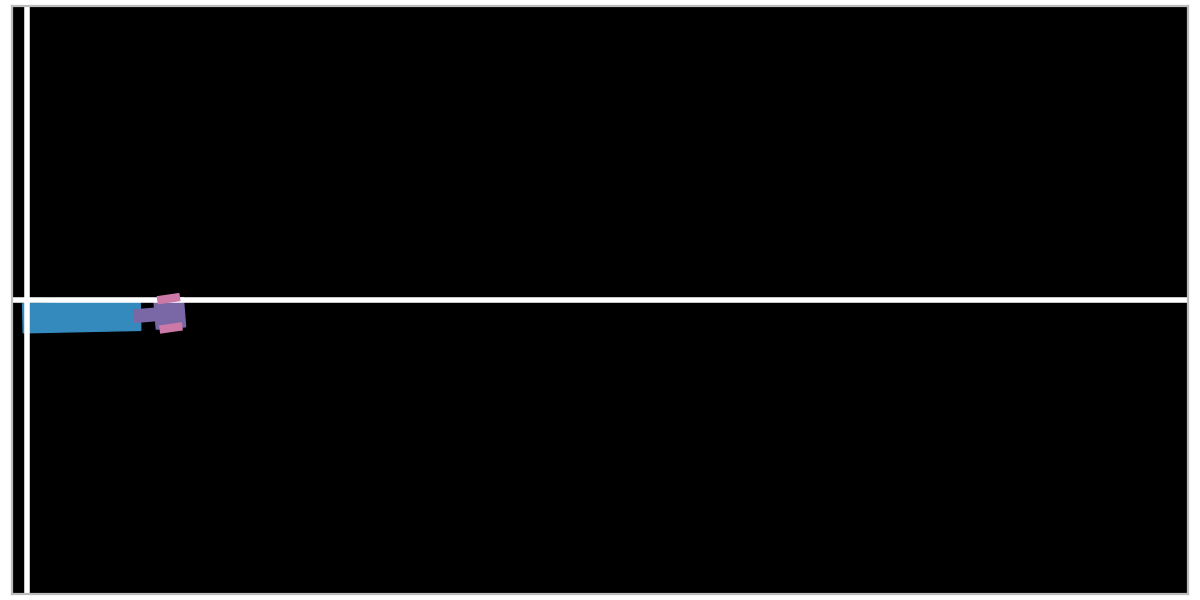

In [15]:
final_lesson = num_lessons + 1
test_controller = torch.load('models/controllers/controller_lesson_{}.pth'.format(final_lesson), weights_only = False)

truck = Truck(lesson = final_lesson, display = True)
truck.reset()

In [29]:
with torch.no_grad():
    truck.reset()
    i = 0
    while truck.valid():
        t1 = torch.tensor([truck.ϕ],dtype=torch.float32)
        state = truck.state()      
        t2 = torch.Tensor(state)
        state = torch.cat((t1,t2))
        ϕ = test_controller(state)
        truck.step(ϕ.item())
        truck.draw()
        i += 1
    print("Number of Steps: {}".format(i))

Number of Steps: 182
